<a href="https://colab.research.google.com/github/Sallyrideauto/sallysdeveloplog/blob/AIFFEL_Project/%5BGoingDeeperNLP_2%5D_Sentencepiece_GPU_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Going Deeper NLP Project 2. Sentencepiece 사용하기

## 📍 About Project
- 네이버 영화리뷰 감정 분석 코퍼스에 `SentencePiece` 적용시킨 모델 학습
- 한국어로 된 `corpus`를 다루어야 하므로 주로 `KoNLPy`에서 제공하는 형태소 분석기를 이용해 텍스트를 전처리
- `RNN` 모델을 분류기로 사용
- 학습된 모델로 `sp_tokenize()` 메소드 구현
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습
- `KoNLPy` 형태소 분석기를 사용한 모델과 성능 비교
- (보너스) `SentencePiece` 모델의 `model_type`, `vocab_size` 등을 변경해 가면서 성능 개선 여부 확인

## 🎯 Rubric
|평가문항|상세기준|
|:-----|:-----|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.|

-----

## 1. 데이터 전처리 & 분석
- 프로젝트에 사용될 라이브러리 `import`
- [링크](https://github.com/e9t/nsmc/)를 통해 네이버 영화 리뷰 데이터셋 다운로드
- 데이터의 결측치와 중복 데이터 제거
- 문장의 최장/최단/평균 길이를 구한 후 문장 길이 분포를 막대 그래프로 시각화
- 데이터 정제 후 문장 길이 분포 역시 막대 그래프로 시각화

In [1]:
pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.1 MB/s 


In [2]:
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:12 http://ppa.launchpad.net/cran/libgit2/u

In [3]:
import os, sys
import pandas as pd
import sentencepiece as spm
import urllib.request
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import konlpy
from konlpy.tag import Mecab
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import Constant
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

mecab = Mecab()

print(tf.__version__)
print(np.__version__)
# print(plt.__version__)
print(konlpy.__version__)

2.8.0
1.21.5
0.6.0


In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", 
                           filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7fb84914cad0>)

In [5]:
ratings_df = pd.read_table('ratings.txt')
ratings_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [6]:
print('리뷰 개수 :', len(ratings_df)) # 리뷰 개수 출력

리뷰 개수 : 200000


In [7]:
# 해당 데이터셋에 Null값이 존재하는지 확인
print(ratings_df.isnull().values.any())
print(ratings_df.isnull().sum)

True
<bound method NDFrame._add_numeric_operations.<locals>.sum of            id  document  label
0       False     False  False
1       False     False  False
2       False     False  False
3       False     False  False
4       False     False  False
...       ...       ...    ...
199995  False     False  False
199996  False     False  False
199997  False     False  False
199998  False     False  False
199999  False     False  False

[200000 rows x 3 columns]>


In [8]:
ratings_df = ratings_df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(ratings_df.isnull().values.any()) # Null 값이 존재하는지 확인
print(ratings_df.isnull().sum)

False
<bound method NDFrame._add_numeric_operations.<locals>.sum of            id  document  label
0       False     False  False
1       False     False  False
2       False     False  False
3       False     False  False
4       False     False  False
...       ...       ...    ...
199995  False     False  False
199996  False     False  False
199997  False     False  False
199998  False     False  False
199999  False     False  False

[199992 rows x 3 columns]>


In [9]:
print('결측치 제거 후 리뷰 개수 :', len(ratings_df))

결측치 제거 후 리뷰 개수 : 199992


In [10]:
cleaned_corpus = ratings_df.drop_duplicates(['document'])   

In [11]:
print('중복 제거 후 리뷰 개수 :', len(cleaned_corpus))

중복 제거 후 리뷰 개수 : 194543


In [12]:
cleaned_corpus.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [13]:
ratings_doc = cleaned_corpus['document']

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


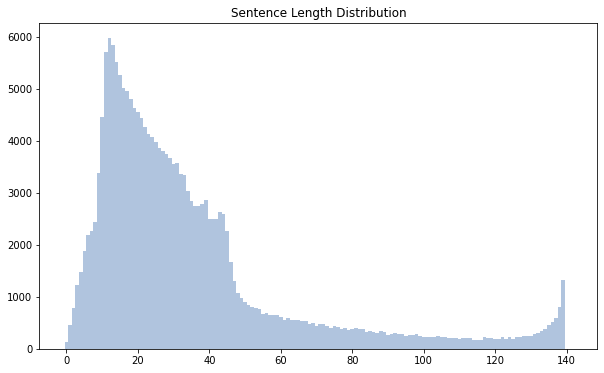

In [14]:
min_len = 999
max_len = 0
sum_len = 0

for sen in ratings_doc:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(ratings_doc))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in ratings_doc:
    sentence_length[len(sen)-1] += 1

plt.figure(figsize=(10,6))
plt.bar(range(max_len), sentence_length, color = 'lightsteelblue', width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [15]:
# 길이가 1개인 문장 확인

def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(ratings_doc, 135)

내가 남자라그런가 이거 겁나 긴장감있고 흥미진진하던데..ㄷㄷ 나만그런가워낙에 격투씬을 좋아해서.ㅋㅋㅋ 그냥 아무생각없이 집에서 스마트티비로 봐서 재밌었나봄 이거 뭔영화인지도 모르고 암살에 나온 이정재 있길래 걍봄 ㅋㅋ 하여튼 너무 재밌게 봤음
줄리아 로버츠의 웃음은 정말 보는 사람을 기쁘게 해준다. 웃음 하나로 기쁨과 슬픔을 표현할 수 있는 배우..전통을 깨고 여성의 새로운 삶을 살으라고 영화는 보여주는 데 영화에서는 전통을 완전히 벗어나야 한다는 것만을 강조하는 것 같아 아쉽다.
평점 왜 이렇게 낮아요??? 영화 대박인데...진짜....ㅋㅋㅋ 와.. 어떻게 이런상상을 해서 이런 영화를... 대박대박.. ㅠ 생각지못한 반전.. 처음엔 반신반의하면서 봤는데.. 최고내요...ㄷㄷㄷ 근데 금발 여주는 중반에 좀 짜증나긴했음ㅋ
큰 기대 안하고 띄엄띄엄 보다가 집중해서 봤네요!! 저는 잘봤습니다. 액션도 뛰어나고 아슬아슬한 장면들을 극복해 가는게 나름 잼있었어요!! 마지막에 여자 박사가 살았는지 죽었는지가 안나와서 좀 아쉽네요..그래도 딸은 살렸으니 다행스럽다는 ㅎㅎ
누군가는 잃고, 누군가는 벌고, 또 누군가는 죽는 게임. 그리고 끊임없이 반복되는 삶과 기억의 굴레. 하지만 시작할 때부터 영화는 이미 심각했고, 지루했다. 다 본 후 생각해보니 그럴 수밖에 없었겠다 싶다. 넓고 얕은 재미, 길고 깊은 여운.
영화내용은 사실별거 없지만 보고나면 생각을 많이하게 되는 영화임. 재미있기도 하고, 결론은 무엇이냐 하면 빨갱이들이 아무것도 모르는 사람들 선동해서 비참한 결과를 낳게 한다는 내용임. 복수심에 불타는 이북출신들도 나오는데 다 역사적인 사실임.
고등학교때 보고 지금에서 생각난 영화 참~그땐 눈물 콧물 흘리면서 봤는데짐 보면 나올라나.. 하긴 세월이 많이 흘렀지 아마 짐 시대하곤 스토리자체가 뻔하니깐 하지만 지금도 잊혀지지않는장면은 주인공이 공부하는장면과하늘도 갈라놓지 못한 그들의사랑
오스카는 흔히 볼수있는 아들이자 장난끼 많은 오빠 그리고 항상 미안해하는 남편. 감정이

In [16]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 135를 초과하는 문장 길이를 추출합니다.
    if _sum > 135:
        print("Outlier Index:", idx+1)

Outlier Index: 2
Outlier Index: 3
Outlier Index: 4
Outlier Index: 5
Outlier Index: 6
Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46
Outlier Index: 47
Outlier Index: 48
Outlier Index: 49
Outlier Index: 50
Outlier Index: 51
Outlier Index: 52
Outlier Index: 53
Outlier Index: 54
Outlier Index: 55
Outlier Index: 56
Outlier Index: 57


In [17]:
check_sentence_with_length(ratings_doc, 1)

굿
핡
휴
시
ㅋ
ㅇ
‥
O
갑
ㅎ
.
올
헷
g
♥
짱
ㅆ
굳
잼
ㅁ
?
애
흠
!
찜
b
,
1
9
♬
ㅗ
ㄳ
ㄴ
호
a
d
f
음
헐
캬
린
업
乃
ㅠ
;
·
k
움
ㄱ
쩜
-
군
ㅉ
훗
z
쨩
뿌
♡
하
h
ㅍ
꽉
토
귯
아
오
ㅣ
봐
웅
네
ㅂ
꿈
헉
와
뻑
걍
헝
우
즛
풉
4
쀍
ㄹ
삼
쒯
즐
함
0
진
악
풋
쩝
욜
ㄷ
흐
싫
ㅜ
잏
허
엿
쉣


In [18]:
check_sentence_with_length(ratings_doc, 10)

내용이너무좋아요.ㅎ
뀰잼이다뀰잼이라구여
13살이엇냐?...
알파치노 연기때문에
이물감. 시 같았다
매력적인 영화...
이거 재밌는데...
.겁쟁이페달보고싶다
한국 영화치고 좋다
정말 멋진 결말!ㅎ
너무 잘 봣어요..
도라에몽 최고~!!
정말 재밋내요..굿
너무끔찍하네요ㅜㅜㅜ
유지태 너무 멌있다
진짜..쩔지..ㅜㅜ
개꿀재밋다뿌잉최고임
박보영 나와서 추천
그냥 재밌습니다^^
카이키는차캤습니다.
이거왜청불임????
소재가 새로웠던..
이거완전 추전!~~
1236547890
평점이왜이래....
조용하고 잔잔한영화
왜안 저스티스리그요
영화의매력에빠졌어요
피터팬너무좋아요ㅠㅠ
엄청재밌어요정의성굳
계속 울었다..ㅜㅜ
재밋다 그외는 없고
재미나요~귀여워요~
내가본한국최고의애니
인간은 자유의 노예
만세!!!!짱재밌음
아날로그적 감성..
완전 재밌다 ㅋㅋㅋ
유덕화아저씨잘생겼다
통일호 화장실 강추
구르재매맴잼잼잼잼젬
아직까지도 여운이.
스크림보다 재밌네!
좋았다.(열자..)
지극히 붉은 영화.
이거죠~이거!!!!
여운이너무많이남아요
스티브잡스가생각나요
제시카 알바 좋아요
정말 잘 만든 사극
나쁘지많은않은...
재밌네 이거 ㅋㅋㅋ
난 너무 재밌엇음~
보.고.싶.다.!!
즐겁게 볼수있었던!
Very good!
여자 걸그룹이 이쁨
7.32 라니 ㅋㅋ
전편 다보고싶다..
좋다~~ 사랑스러운
진짜감동이다감동이야
나는 재미있게 봤다
애니의새로운 개척점
감동이 있는 이야기
재미있게 봤어요^^
가나다라마바사아자차
좋아요정말좋아요정말
엄청재밌어요꼭보세요
정말 잘 만들어졌음
넝쿨째굴러온당신짱!
야하지만 좀 재밌다
정말대단한거같다는ㅋ
굿굿굿굿굯굿굿굿귯귯
이것도 꽤 명작이지
최고의 영화중 한편
잔잔한 멋이 있네요
겁나재밌었음!!!!
내인생최고의액션영화
감동의 물결....
볼만함~재밋음~굿굿
정말재밌게잘봤습니다
장근석존잘박신혜존예
솔직히 재밌다 ㅋㅋ
늘 감동이었네요..
배울점이많은영화ㅋㅋ
일주일만에 다봣다.
재미있게 본 영화~
멋지고 감동적이다.
너무 좋은 영화예요
이영아 넘 이뻐^^
붉은매다시보고싶다.

Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


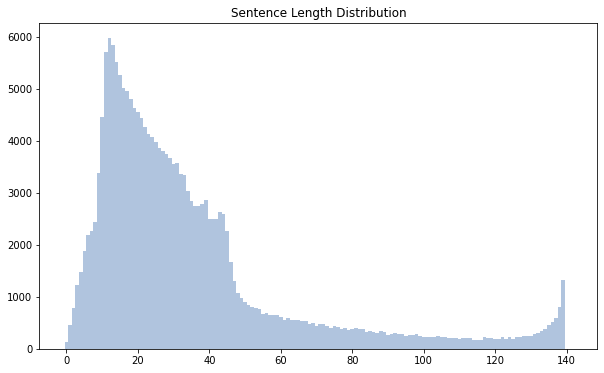

In [19]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(ratings_doc))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.figure(figsize=(10,6))
plt.bar(range(max_len), sentence_length, color = 'lightsteelblue', width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [20]:
# 최적의 max_len 찾기

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [21]:
below_threshold_len(36, ratings_doc)  # 평균
below_threshold_len(140, ratings_doc)  # 최장 
below_threshold_len(70, ratings_doc)  # 중앙값
below_threshold_len(100, ratings_doc)  
below_threshold_len(60, ratings_doc)
below_threshold_len(11, ratings_doc) 

전체 샘플 중 길이가 36 이하인 샘플의 비율: 66.08616090016089
전체 샘플 중 길이가 140 이하인 샘플의 비율: 99.99948597482305
전체 샘플 중 길이가 70 이하인 샘플의 비율: 88.66523082300571
전체 샘플 중 길이가 100 이하인 샘플의 비율: 94.05529882853662
전체 샘플 중 길이가 60 이하인 샘플의 비율: 85.86739178484962
전체 샘플 중 길이가 11 이하인 샘플의 비율: 10.632610785276263


Data Size: 182732
문장의 최단 길이: 0
문장의 최장 길이: 100
문장의 평균 길이: 38


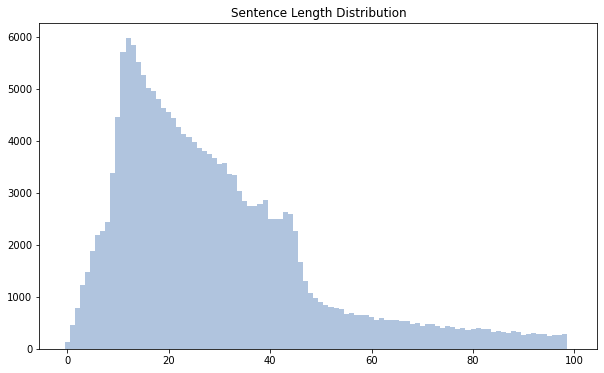

In [22]:
max_len = 100
min_len = 0

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

print("Data Size:", len(filtered_corpus))

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(filtered_corpus))

plt.figure(figsize=(10,6))
plt.bar(range(max_len), sentence_length, color = 'lightsteelblue', width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [23]:
sentence_length

array([ 124,  460,  793, 1222, 1469, 1882, 2187, 2270, 2440, 3379, 4459,
       5711, 5970, 5848, 5518, 5265, 5005, 4947, 4806, 4626, 4542, 4436,
       4264, 4129, 4073, 3973, 3865, 3809, 3743, 3665, 3561, 3566, 3353,
       3339, 3036, 2831, 2736, 2736, 2775, 2856, 2486, 2486, 2495, 2625,
       2599, 2257, 1660, 1311, 1079,  968,  893,  844,  799,  789,  765,
        678,  686,  654,  658,  648,  614,  554,  600,  555,  544,  554,
        528,  528,  473,  493,  443,  477,  469,  443,  403,  437,  422,
        388,  398,  365,  372,  398,  380,  381,  326,  350,  327,  308,
        333,  332,  260,  286,  300,  281,  291,  255,  261,  271,  283,
          0])

In [24]:
print('전처리 전 데이터 개수 :', len(ratings_df))
print('전처리 후 데이터 개수 :', len(filtered_corpus))
print('전처리 후 남은 데이터 양(%)', (len(filtered_corpus)/len(ratings_df))*100)

전처리 전 데이터 개수 : 199992
전처리 후 데이터 개수 : 182732
전처리 후 남은 데이터 양(%) 91.36965478619145


-----

## 2. 공백 기반 토큰화
- 정제된 데이터를 공백 기반으로 토큰화하여 `list`에 저장
- `tokenize()` 함수를 사용해 단어 사전과 `Tensor` 데이터를 얻은 후, 단어 사전의 크기 확인
- 공백 기반 토큰화의 문제점
  - 불필요하게 큰 단어 사전을 가지게 되어, 연산량 증가로 이어짐

In [25]:
# 정제된 데이터를 공백 기반으로 토큰화

def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [26]:
# 정제된 데이터를 공백 기반으로 토큰화하여 저장
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

In [27]:
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 367047


In [28]:
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 영화
1 : 너무
2 : 정말
3 : 진짜
4 : 이
5 : 영화.
6 : 왜
7 : 이런
8 : 그냥
9 : 더
10 : 수
11 : 영화를


-----

## 3. 형태소 기반 토큰화
- `KoNLPy`의 `MeCab` 클래스를 이용하여 형태소 기반으로 토큰화
- 위의 공백 기반 토큰화 결과에 비해 단어 수가 현저히 줄어든 것을 확인할 수 있음
  - 이는 연산량의 감소로 이어져 더 빠른 학습을 가능하게 함
  - 모델이 튜닝해야 하는 매개변수(`Parameter`) 수 역시 감소하여 효율적인 학습 가능
- 두 가지 방법을 이용한 `Decoding`
  1. `tokenizer.sequences_to_texts()` 함수
  2. `tokenizer.index_word`

In [29]:
# 위에서 사용한 코드를 활용해 MeCab 단어 사전을 만들어보세요. 
# Hint : mecab.morphs()를 사용해서 형태소분석을 합니다.
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

In [30]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 54293


In [31]:
# Case 1 : tokenizer.sequences_to_texts()

texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
print(texts[0])

진짜 명작 이 다 . 우디앨런 식 재치 와 연기 모두 에 시간 가 는 줄 모를 정도


In [32]:
# Case 2 : tokenizer.index_word

sentence = ""

for w in mecab_tensor[100]:
    if w == 0: continue
    sentence += mecab_tokenizer.index_word[w] + " "

print(sentence)

진짜 명작 이 다 . 우디앨런 식 재치 와 연기 모두 에 시간 가 는 줄 모를 정도 


-----

## 4. Sentencepiece 사용하기
- 우선, 학습 데이터를 불러온 뒤 결측치와 중복을 제거하는 정제 작업 수행
- `Google Sentencepiece`
  - 구글이 `BPE` 알고리즘과 `Unigram Language Model Tokenizer`를 구현하여 `github`에 공개한 패키지
  - 사전 토큰화 작업(`pretokenization`) 없이 전처리를 하지 않은 데이터(`raw data`)에 바로 분리 토크나이저를 사용할 수 있어 어떤 언어에도 적용 가능한 점을 살려서 구현
  - 사전 토큰화 작업 없이 단어 분리 토큰화를 수행하므로 언어에 종속되지 않음
- 유니그램(`Unigram`)
    - 가장 단순한 언어 모델
    - 각 단어가 서로 독립(`independent`)적이라고 가정
    - 단어의 시퀀스를 고려하기보다 단어의 `set`을 상정한다는 쪽이 더 정확한 표현
    → 각 단어의 등장 순서가 바뀌어도 개별 단어 확룔의 곱은 변하지 않음을 의미
- `BPE(Byte Pair Encoding)`
    - 1994년 제안된 데이터 압축 알고리즘으로, 후에 자연어 처리의 서브워드 분리(`subword segmentation`) 알고리즘으로 응용되고 있음
    - 기본적으로 연속적으로 가장 많이 등장한 글자의 쌍을 찾아서 하나의 글자로 병합하는 방식을 수행
    - 글자 단위에서 점차적으로 단어 집합을 만들어 내는 `bottom up` 접근 방식을 사용
        - 훈련 데이터에 있는 단어들을 모든 글자 또는 유니코드 단위로 단어 집합 생성
        - 가장 많이 등장하는 유니그램을 하나의 유니그램으로 통합

In [33]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
train_data = pd.read_table('ratings_train.txt')

In [34]:
print(train_data.isnull().sum())

id          0
document    5
label       0
dtype: int64


In [35]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [36]:
train_data = train_data.drop_duplicates(['document'])   
print('중복 제거 후 리뷰 개수 :', len(train_data))

중복 제거 후 리뷰 개수 : 146182


In [37]:
import sentencepiece as spm
import os

vocab_size = 8000

with open('ratings_doc.txt', 'w') as f:
    for row in train_data['document']:
      f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train('--input=ratings_doc.txt --model_prefix=naver_4k --vocab_size=4000')
spm.SentencePieceTrainer.Train('--input=ratings_doc.txt --model_prefix=naver_8k --vocab_size=8000')
spm.SentencePieceTrainer.Train('--input=ratings_doc.txt --model_prefix=naver_16k --vocab_size=16000')
spm.SentencePieceTrainer.Train('--input=ratings_doc.txt --model_prefix=naver_bpe_4k --model_type=bpe --vocab_size=4000')
spm.SentencePieceTrainer.Train('--input=ratings_doc.txt --model_prefix=naver_bpe_8k --model_type=bpe --vocab_size=8000')
spm.SentencePieceTrainer.Train('--input=ratings_doc.txt --model_prefix=naver_bpe_16k --model_type=bpe --vocab_size=16000')

# 위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

In [38]:
! ls -l naver_4k*
! ls -l naver_8k*
! ls -l naver_16k*
! ls -l naver_bpe_4k*
! ls -l naver_bpe_8k*
! ls -l naver_bpe_16k*

-rw-r--r-- 1 root root 298357 Mar 23 13:37 naver_4k.model
-rw-r--r-- 1 root root  64269 Mar 23 13:37 naver_4k.vocab
-rw-r--r-- 1 root root 374602 Mar 23 13:37 naver_8k.model
-rw-r--r-- 1 root root 144146 Mar 23 13:37 naver_8k.vocab
-rw-r--r-- 1 root root 534076 Mar 23 13:38 naver_16k.model
-rw-r--r-- 1 root root 310619 Mar 23 13:38 naver_16k.vocab
-rw-r--r-- 1 root root 296990 Mar 23 13:38 naver_bpe_4k.model
-rw-r--r-- 1 root root  50245 Mar 23 13:38 naver_bpe_4k.vocab
-rw-r--r-- 1 root root 370217 Mar 23 13:38 naver_bpe_8k.model
-rw-r--r-- 1 root root 115472 Mar 23 13:38 naver_bpe_8k.vocab
-rw-r--r-- 1 root root 523133 Mar 23 13:38 naver_bpe_16k.model
-rw-r--r-- 1 root root 258384 Mar 23 13:38 naver_bpe_16k.vocab


In [39]:
vocab_4k_list = pd.read_csv('naver_4k.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
print('subword의 개수 :', len(vocab_4k_list))
vocab_4k_list[:10]

subword의 개수 : 4000


,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,▁,-2.77002
4,.,-3.63402
5,이,-4.14894
6,가,-4.52020
7,..,-4.53186
8,의,-4.64666
9,▁영화,-4.65459


In [40]:
vocab_8k_list = pd.read_csv('naver_8k.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
print('subword의 개수 :', len(vocab_8k_list))
vocab_8k_list[:10]

subword의 개수 : 8000


,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,▁,-3.23816
4,.,-3.48155
5,..,-4.39200
6,이,-4.41956
7,▁영화,-4.58614
8,...,-4.63659
9,의,-4.69503


In [41]:
vocab_16k_list = pd.read_csv('naver_16k.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
print('subword의 개수 :', len(vocab_16k_list))
vocab_16k_list[:10]

subword의 개수 : 16000


,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,.,-3.36023
4,▁,-3.50125
5,..,-4.28657
6,▁영화,-4.53487
7,...,-4.53757
8,이,-4.64428
9,의,-4.71977


In [42]:
vocab_bpe_4k_list = pd.read_csv('naver_bpe_4k.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
print('subword의 개수 :', len(vocab_bpe_4k_list))
vocab_bpe_4k_list[:10]

subword의 개수 : 4000


,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1
5,▁영화,-2
6,▁이,-3
7,▁아,-4
8,...,-5
9,▁그,-6


In [43]:
vocab_bpe_8k_list = pd.read_csv('naver_bpe_8k.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
print('subword의 개수 :', len(vocab_bpe_8k_list))
vocab_bpe_8k_list[:10]

subword의 개수 : 8000


,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1
5,▁영화,-2
6,▁이,-3
7,▁아,-4
8,...,-5
9,▁그,-6


In [44]:
vocab_bpe_16k_list = pd.read_csv('naver_bpe_16k.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
print('subword의 개수 :', len(vocab_bpe_16k_list))
vocab_bpe_16k_list[:10]

subword의 개수 : 16000


,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1
5,▁영화,-2
6,▁이,-3
7,▁아,-4
8,...,-5
9,▁그,-6


In [45]:
print(len(vocab_4k_list))
print(len(vocab_8k_list))
print(len(vocab_16k_list))
print(len(vocab_bpe_4k_list))
print(len(vocab_bpe_8k_list))
print(len(vocab_bpe_16k_list))

4000
8000
16000
4000
8000
16000


In [46]:
sp_4k = spm.SentencePieceProcessor()
vocab_file = "naver_4k.model"
print(sp_4k.load(vocab_file))
sp_8k = spm.SentencePieceProcessor()
vocab_file = "naver_8k.model"
print(sp_8k.load(vocab_file))
sp_16k = spm.SentencePieceProcessor()
vocab_file = "naver_16k.model"
print(sp_16k.load(vocab_file))
sp_bpe_4k = spm.SentencePieceProcessor()
vocab_file = "naver_bpe_4k.model"
print(sp_bpe_4k.load(vocab_file))
sp_bpe_8k = spm.SentencePieceProcessor()
vocab_file = "naver_bpe_8k.model"
print(sp_bpe_8k.load(vocab_file))
sp_bpe_16k = spm.SentencePieceProcessor()
vocab_file = "naver_bpe_16k.model"
print(sp_bpe_16k.load(vocab_file))

True
True
True
True
True
True


In [47]:
lines = [
         "뭐 이딴 것도 영화냐.", 
         "진짜 최고의 영화입니다 ㅋㅋ"
         ]

for line in lines:
  print(line)
  print(sp_4k.encode_as_pieces(line))
  print(sp_4k.encode_as_ids(line))
  print()
  print(sp_8k.encode_as_pieces(line))
  print(sp_8k.encode_as_ids(line))
  print()
  print(sp_16k.encode_as_pieces(line))
  print(sp_16k.encode_as_ids(line))
  print()
  print(sp_bpe_4k.encode_as_pieces(line))
  print(sp_bpe_4k.encode_as_ids(line))
  print()
  print(sp_bpe_8k.encode_as_pieces(line))
  print(sp_bpe_8k.encode_as_ids(line))
  print()
  print(sp_bpe_16k.encode_as_pieces(line))
  print(sp_bpe_16k.encode_as_ids(line))
  print()  

뭐 이딴 것도 영화냐.
['▁뭐', '▁이딴', '▁것도', '▁영화', '냐', '.']
[178, 1067, 1789, 9, 135, 4]

['▁뭐', '▁이딴', '▁것도', '▁영화냐', '.']
[166, 1075, 1250, 3550, 4]

['▁뭐', '▁이딴', '▁것도', '▁영화냐', '.']
[149, 1098, 908, 2797, 3]

['▁뭐', '▁이딴', '▁것도', '▁영화', '냐', '.']
[124, 961, 1273, 5, 2502, 2288]

['▁뭐', '▁이딴', '▁것도', '▁영화냐', '.']
[124, 961, 1273, 2942, 6288]

['▁뭐', '▁이딴', '▁것도', '▁영화냐', '.']
[124, 961, 1273, 2942, 14288]

진짜 최고의 영화입니다 ㅋㅋ
['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[41, 174, 922, 162]

['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[31, 118, 668, 111]

['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[28, 90, 485, 81]

['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[54, 209, 820, 85]

['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[54, 209, 820, 85]

['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[54, 209, 820, 85]



In [48]:
# 단어 집합의 크기 확인
print(sp_4k.GetPieceSize())
print(sp_8k.GetPieceSize())
print(sp_16k.GetPieceSize())
print(sp_bpe_4k.GetPieceSize())
print(sp_bpe_8k.GetPieceSize())
print(sp_bpe_16k.GetPieceSize())

4000
8000
16000
4000
8000
16000


In [49]:
# 정수로부터 맵핑되는 서브 워드로 변환
print(sp_4k.IdToPiece(10))
print(sp_8k.IdToPiece(10))
print(sp_16k.IdToPiece(10))
print(sp_bpe_4k.IdToPiece(10))
print(sp_bpe_8k.IdToPiece(10))
print(sp_bpe_16k.IdToPiece(10))

도
가
,
▁보
▁보
▁보


In [50]:
# 서브워드로부터 맵핑되는 정수로 변환
print(sp_4k.PieceToId('영화'))
print(sp_8k.PieceToId('영화'))
print(sp_16k.PieceToId('영화'))
print(sp_bpe_4k.PieceToId('영화'))
print(sp_bpe_8k.PieceToId('영화'))
print(sp_bpe_16k.PieceToId('영화'))

28
32
33
4
4
4


In [51]:
# 정수 시퀀스로부터 문장으로 변환
print(sp_4k.DecodeIds([54, 200, 821, 85]))
print(sp_8k.DecodeIds([54, 200, 821, 85]))
print(sp_16k.DecodeIds([54, 200, 821, 85]))
print(sp_bpe_4k.DecodeIds([54, 200, 821, 85]))
print(sp_bpe_8k.DecodeIds([54, 200, 821, 85]))
print(sp_bpe_16k.DecodeIds([54, 200, 821, 85]))

와무 애니할
요 생각 보세요하게
그냥용봄야
진짜 마지막 그저 ᄏᄏ
진짜 마지막 그저 ᄏᄏ
진짜 마지막 그저 ᄏᄏ


In [52]:
# 서브워드 시퀀스로부터 문장으로 변환
print(sp_4k.DecodePieces(['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']))
print(sp_8k.DecodePieces(['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']))
print(sp_16k.DecodePieces(['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']))
print(sp_bpe_4k.DecodePieces(['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']))
print(sp_bpe_8k.DecodePieces(['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']))
print(sp_bpe_16k.DecodePieces(['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']))

진짜 최고의 영화입니다 ᄏᄏ
진짜 최고의 영화입니다 ᄏᄏ
진짜 최고의 영화입니다 ᄏᄏ
진짜 최고의 영화입니다 ᄏᄏ
진짜 최고의 영화입니다 ᄏᄏ
진짜 최고의 영화입니다 ᄏᄏ


In [53]:
# 문장으로부터 인자값에 따라서 정수 시퀀스 또는 서브워드 시퀀스로 변환 가능
print(sp_4k.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=str))
print(sp_4k.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=int))
print(sp_8k.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=str))
print(sp_8k.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=int))
print(sp_16k.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=str))
print(sp_16k.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=int))
print(sp_bpe_4k.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=str))
print(sp_bpe_4k.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=int))
print(sp_bpe_8k.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=str))
print(sp_bpe_8k.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=int))
print(sp_bpe_16k.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=str))
print(sp_bpe_16k.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=int))

['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[41, 174, 922, 162]
['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[31, 118, 668, 111]
['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[28, 90, 485, 81]
['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[54, 209, 820, 85]
['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[54, 209, 820, 85]
['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[54, 209, 820, 85]


In [54]:
def test_performance(model):
  s = spm.SentencePieceProcessor()
  s.Load(model)
  
  # SentencePiece를 활용한 sentence -> encoding
  tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
  print(tokensIDs)

  # SentencePiece를 활용한 sentence -> encoded pieces
  print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

  # SentencePiece를 활용한 encoding -> sentence 복원
  print(s.DecodeIds(tokensIDs))

In [55]:
print('Unigram 4k')
print(test_performance(model='naver_4k.model'))
print('Unigram 8k')
print(test_performance(model='naver_8k.model'))
print('Unigram 16k')
print(test_performance(model='naver_16k.model'))
print('Byte Pair Encoding 4k')
print(test_performance(model='naver_bpe_4k.model'))
print('Byte Pair Encoding 8k')
print(test_performance(model='naver_bpe_8k.model'))
print('Byte Pair Encoding 16k')
print(test_performance(model='naver_bpe_16k.model'))

Unigram 4k
[1872, 6, 330, 16, 1745, 6, 108, 13, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
None
Unigram 8k
[1400, 10, 389, 15, 1324, 10, 123, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
None
Unigram 16k
[7251, 427, 15, 11256, 192, 19, 3]
['▁아버지가', '방', '에', '들어가', '신', '다', '.']
아버지가방에들어가신다.
None
Byte Pair Encoding 4k
[7, 2473, 879, 2552, 2300, 1404, 2296, 2396, 2290, 2288]
['▁아', '버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
None
Byte Pair Encoding 8k
[4851, 879, 6552, 6300, 1404, 6296, 6396, 6290, 6288]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
None
Byte Pair Encoding 16k
[7339, 12731, 1404, 14296, 14396, 14290, 14288]
['▁아버지가', '방에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
None


In [56]:
def sp_tokenize(s, corpus, spm):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./{}.vocab".format(spm), 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'pre', maxlen = max_len)

    return tensor, word_index, index_word

In [57]:
# sp_tokenize(s, corpus) 사용 예제

s = spm.SentencePieceProcessor()
s.Load('naver_8k.model') 

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 'naver_8k')           
print(tensor)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  582 2880   14 1236
  1854    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0 1502 2464  319  572

-----

## 5. 모델 학습 및 테스트
- 우선, 학습 데이터를 불러온 뒤 결측치와 중복을 제거하는 정제 작업 수행
- 다음으로 `LSTM` 모델을 사용하여 학습 및 테스트 수행
  - `LSTM`이 가진 게이트(`gate`)라는 구조 덕분에 시계열 데이터의 장기 의존 관계를 자동으로 학습할 수 있음
    <img src="https://i.ibb.co/7jVhg2y/fig-6-13.png">
  - 입력과 가중치를 곱하고 절편을 더해 활성화 함수를 통과시키는 구조를 여러 개 가짐
  - 은닉층의 메모리 셀에 입력 게이트, 망각 게이트, 출력 게이트를 추가하여 불필요한 기억을 지우고, 기억해야 할 것들을 결정
    <Img src="https://wikidocs.net/images/page/22888/vaniila_rnn_and_different_lstm_ver2.PNG">
  - `RNN`과 비교하여 긴 시퀀스의 입력을 처리하는데 탁월한 성능

In [58]:
tensor, word_index, index_word = sp_tokenize(s, train_data['document'], 'naver_8k')

In [59]:
from sklearn.model_selection import train_test_split

filtered_label = np.array(train_data['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size = 0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2)

In [60]:
print(len(x_train), len(x_test), len(x_val))
print(len(y_train), len(y_test), len(y_val))

93556 23389 29237
93556 23389 29237


In [61]:
vocab_size = vocab_size
word_vector_dim = 32  
epochs = 10
batch_size = 64

cp = tf.keras.callbacks.ModelCheckpoint('best-lstm-model.h5', 
                                        save_best_only = True)

es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', 
                                      verbose = 1, patience = 4)


model_LSTM = tf.keras.Sequential()
model_LSTM.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim))
model_LSTM.add(tf.keras.layers.LSTM(128, dropout = 0.3))
model_LSTM.add(tf.keras.layers.Dense(1, activation='sigmoid'))  
model_LSTM.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])
history_LSTM = model_LSTM.fit(x_train, y_train,
                  epochs = epochs,
                  batch_size = batch_size,
                  validation_data = (x_val, y_val),
                  callbacks = [cp, es],
                  verbose = 1)

model_LSTM.summary()

Epoch 1/10
1462/1462 [==============================] - 22s 11ms/step - loss: 0.4121 - accuracy: 0.8105 - val_loss: 0.3521 - val_accuracy: 0.8469
Epoch 2/10
1462/1462 [==============================] - 15s 10ms/step - loss: 0.3265 - accuracy: 0.8593 - val_loss: 0.3365 - val_accuracy: 0.8544
Epoch 3/10
1462/1462 [==============================] - 15s 10ms/step - loss: 0.2953 - accuracy: 0.8735 - val_loss: 0.3358 - val_accuracy: 0.8553
Epoch 4/10
1462/1462 [==============================] - 15s 10ms/step - loss: 0.2697 - accuracy: 0.8854 - val_loss: 0.3366 - val_accuracy: 0.8554
Epoch 5/10
1462/1462 [==============================] - 15s 10ms/step - loss: 0.2485 - accuracy: 0.8952 - val_loss: 0.3439 - val_accuracy: 0.8520
Epoch 6/10
1462/1462 [==============================] - 15s 10ms/step - loss: 0.2316 - accuracy: 0.9029 - val_loss: 0.3592 - val_accuracy: 0.8524
Epoch 7/10
1462/1462 [==============================] - 15s 10ms/step - loss: 0.2160 - accuracy: 0.9104 - val_loss: 0.3619 -

In [62]:
results = model_LSTM.evaluate(x_test, y_test, verbose = 2)
print(results)

731/731 - 3s - loss: 0.3551 - accuracy: 0.8495 - 3s/epoch - 4ms/step
[0.355074405670166, 0.849459171295166]


In [63]:
def performance_test_spm(spm_model, vocab_size, word_vector_dim):
    s = spm.SentencePieceProcessor()
    s.Load("{}.model".format(spm_model)) 
    
    tensor, word_index, index_word = sp_tokenize(s, train_data['document'], spm_model)

    filtered_label = np.array(train_data['label'])
    x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size = 0.2, random_state = 42)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

    model_LSTM = tf.keras.Sequential()
    model_LSTM.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim))
    model_LSTM.add(tf.keras.layers.LSTM(128, dropout = 0.3))
    model_LSTM.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

    model_LSTM.summary()

    model_LSTM.compile(optimizer = 'adam',
                       loss = 'binary_crossentropy',
                       metrics = ['accuracy'])

    vocab_size = vocab_size
    epochs = 10
    batch_size = 64

    cp = tf.keras.callbacks.ModelCheckpoint('best-lstm-model.h5', 
                                            save_best_only = True)

    es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', 
                                          verbose = 1, patience = 4)

    history_LSTM = model_LSTM.fit(x_train, y_train,
                      epochs = epochs,
                      batch_size = batch_size,
                      validation_data = (x_val, y_val),
                      callbacks = [cp, es],
                      verbose = 1)
    results = model_LSTM.evaluate(x_test, y_test, verbose = 2)
    print(results)

    return history_LSTM

In [64]:
history_unigram_4k_dim_8 = performance_test_spm('naver_4k', vocab_size, word_vector_dim=8)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 8)           64000     
                                                                 
 lstm_1 (LSTM)               (None, 128)               70144     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 134,273
Trainable params: 134,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1462/1462 [==============================] - 17s 10ms/step - loss: 0.4437 - accuracy: 0.7888 - val_loss: 0.3761 - val_accuracy: 0.8342
Epoch 2/10
1462/1462 [==============================] - 15s 10ms/step - loss: 0.3676 - accuracy: 0.8375 - val_loss: 0.3706 - val_accuracy: 0.8381
Epoch 3/10
1462/1462

In [65]:
def visualize_train(train_history, param):
    
    # summarize history for accuracy
    plt.figure(figsize=(10,6))
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('{}_accuracy'.format(param))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.figure(figsize=(10,6))
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('{}_loss'.format(param))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

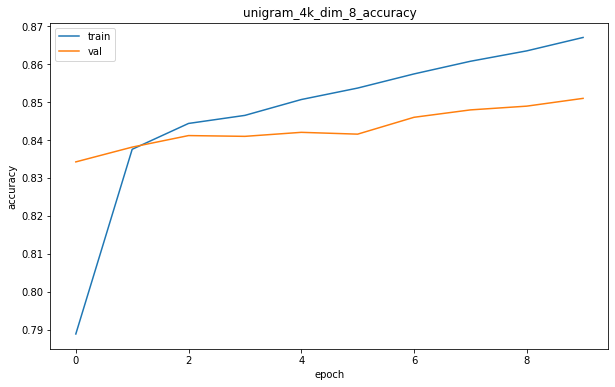

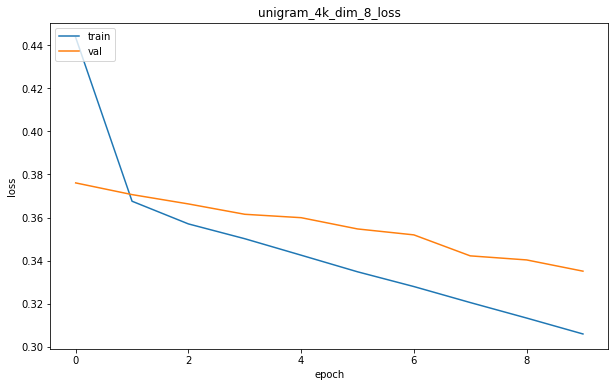

In [66]:
visualize_train(history_unigram_4k_dim_8, param='unigram_4k_dim_8')

In [67]:
history_unigram_4k_dim_16 = performance_test_spm('naver_4k', vocab_size, word_vector_dim=16)
history_unigram_4k_dim_32 = performance_test_spm('naver_4k', vocab_size, word_vector_dim=32)
history_unigram_4k_dim_64 = performance_test_spm('naver_4k', vocab_size, word_vector_dim=64)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          128000    
                                                                 
 lstm_2 (LSTM)               (None, 128)               74240     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 202,369
Trainable params: 202,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1462/1462 [==============================] - 18s 10ms/step - loss: 0.4285 - accuracy: 0.7990 - val_loss: 0.3793 - val_accuracy: 0.8324
Epoch 2/10
1462/1462 [==============================] - 15s 10ms/step - loss: 0.3870 - accuracy: 0.8269 - val_loss: 0.3844 - val_accuracy: 0.8306
Epoch 3/10
1462/1462

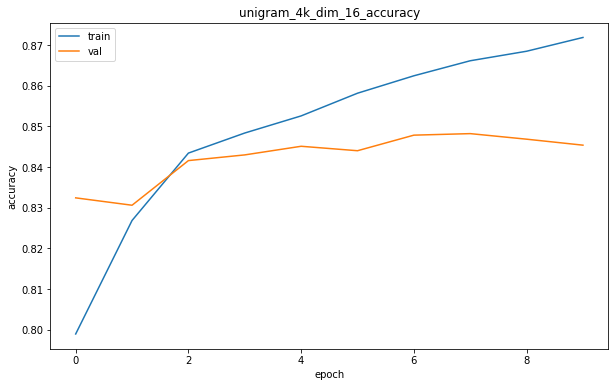

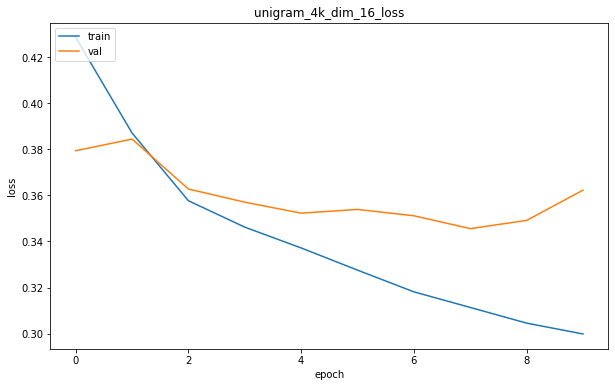

In [68]:
visualize_train(history_unigram_4k_dim_16, param='unigram_4k_dim_16')

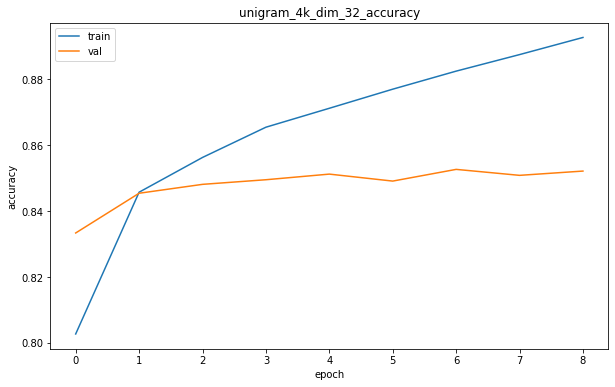

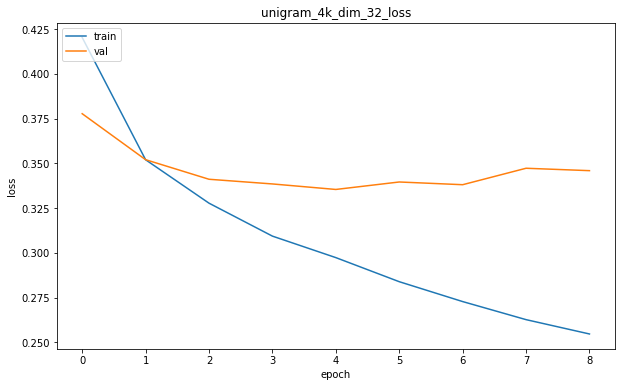

In [69]:
visualize_train(history_unigram_4k_dim_32, param='unigram_4k_dim_32')

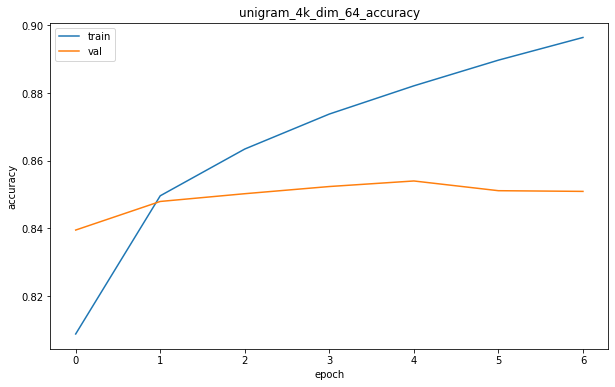

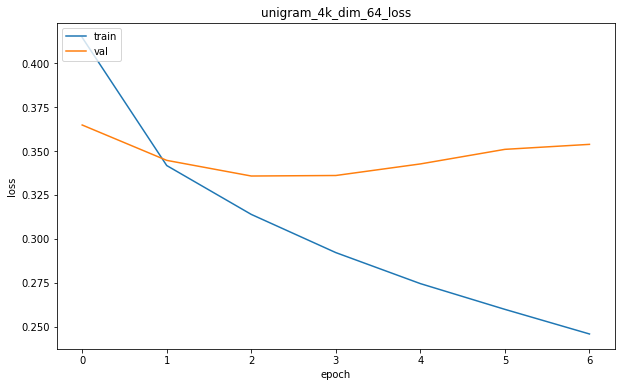

In [70]:
visualize_train(history_unigram_4k_dim_64, param='unigram_4k_dim_64')

In [71]:
history_unigram_8k_dim_8 = performance_test_spm('naver_8k', vocab_size, word_vector_dim=8)
history_unigram_8k_dim_16 = performance_test_spm('naver_8k', vocab_size, word_vector_dim=16)
history_unigram_8k_dim_32 = performance_test_spm('naver_8k', vocab_size, word_vector_dim=32)
history_unigram_8k_dim_64 = performance_test_spm('naver_8k', vocab_size, word_vector_dim=64)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 8)           64000     
                                                                 
 lstm_5 (LSTM)               (None, 128)               70144     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 134,273
Trainable params: 134,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1462/1462 [==============================] - 17s 10ms/step - loss: 0.4405 - accuracy: 0.7926 - val_loss: 0.3614 - val_accuracy: 0.8438
Epoch 2/10
1462/1462 [==============================] - 15s 10ms/step - loss: 0.3415 - accuracy: 0.8522 - val_loss: 0.3520 - val_accuracy: 0.8474
Epoch 3/10
1462/1462

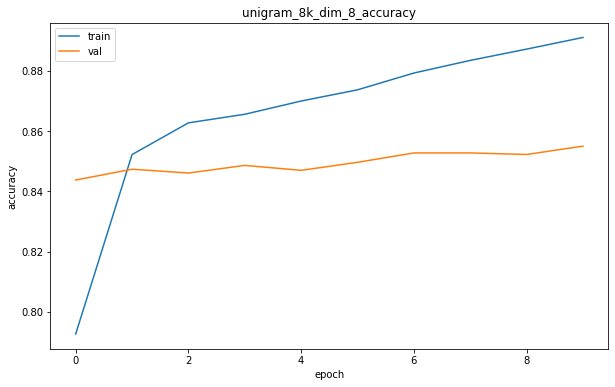

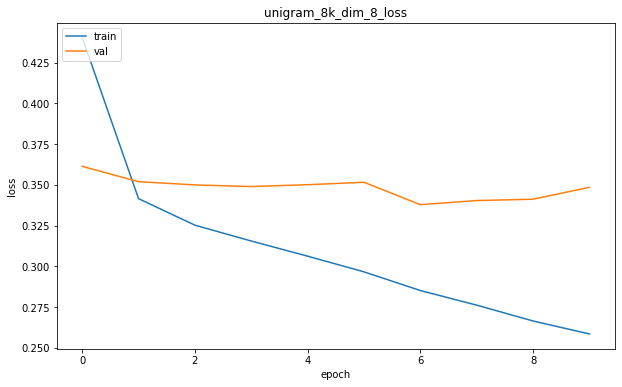

In [72]:
visualize_train(history_unigram_8k_dim_8, param='unigram_8k_dim_8')

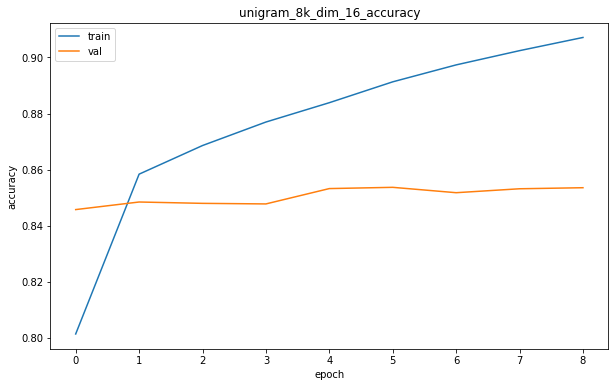

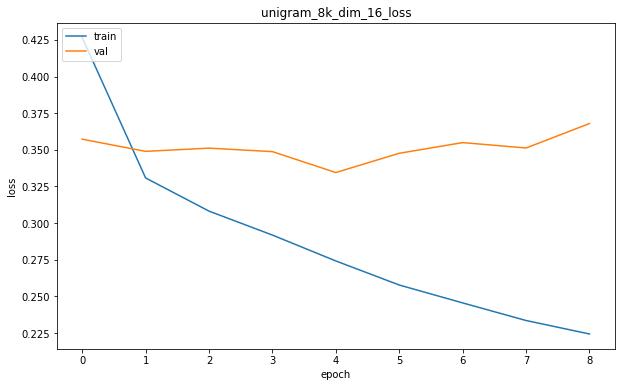

In [73]:
visualize_train(history_unigram_8k_dim_16, param='unigram_8k_dim_16')

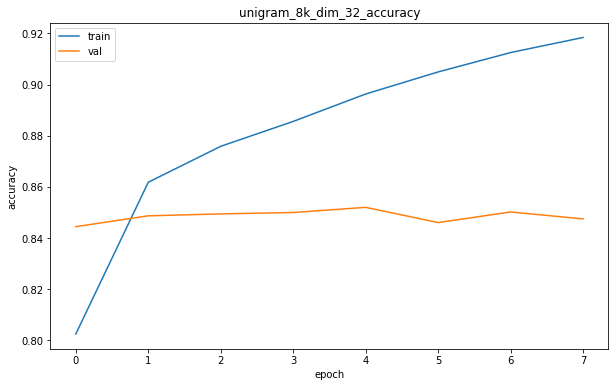

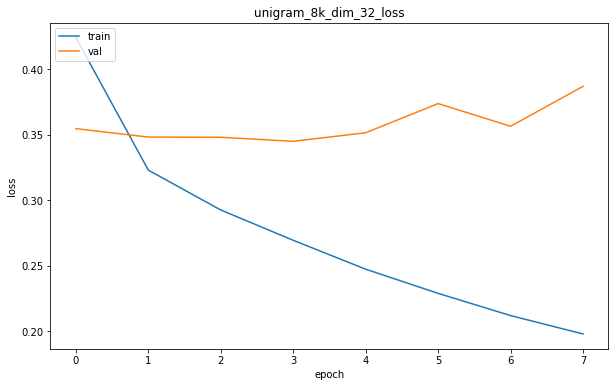

In [74]:
visualize_train(history_unigram_8k_dim_32, param='unigram_8k_dim_32')

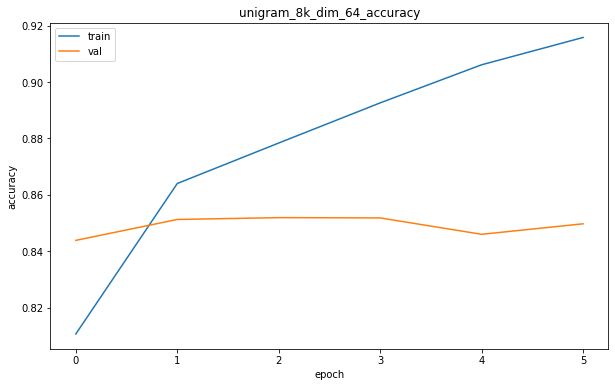

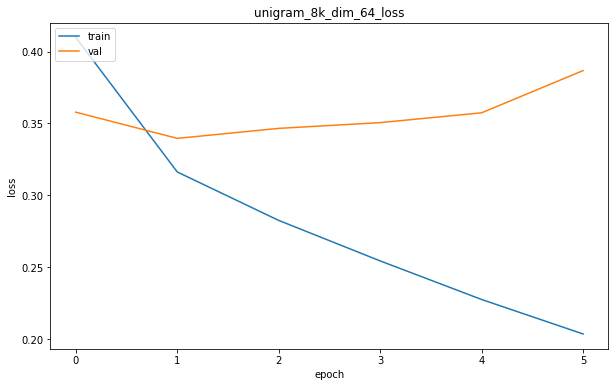

In [75]:
visualize_train(history_unigram_8k_dim_64, param='unigram_8k_dim_64')

In [76]:
history_unigram_16k_dim_8 = performance_test_spm('naver_16k', vocab_size, word_vector_dim=8)
history_unigram_16k_dim_16 = performance_test_spm('naver_16k', vocab_size, word_vector_dim=16)
history_unigram_16k_dim_32 = performance_test_spm('naver_16k', vocab_size, word_vector_dim=32)
history_unigram_16k_dim_64 = performance_test_spm('naver_16k', vocab_size, word_vector_dim=64)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 8)           64000     
                                                                 
 lstm_9 (LSTM)               (None, 128)               70144     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 134,273
Trainable params: 134,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1462/1462 [==============================] - 17s 10ms/step - loss: 0.4689 - accuracy: 0.7732 - val_loss: 0.3890 - val_accuracy: 0.8293
Epoch 2/10
1462/1462 [==============================] - 15s 10ms/step - loss: 0.3618 - accuracy: 0.8403 - val_loss: 0.3783 - val_accuracy: 0.8314
Epoch 3/10
1462/1462

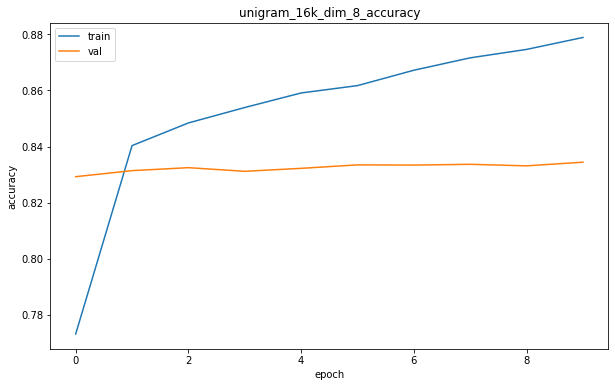

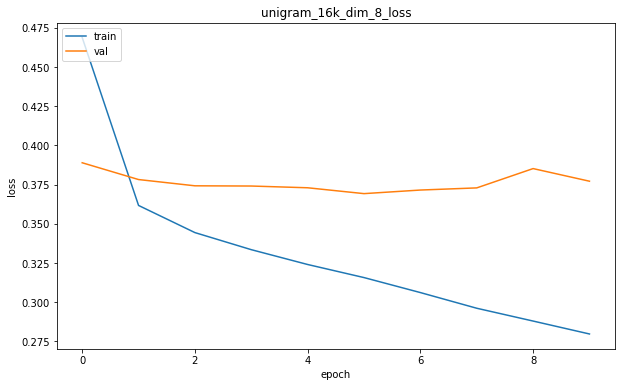

In [77]:
visualize_train(history_unigram_16k_dim_8, param='unigram_16k_dim_8')

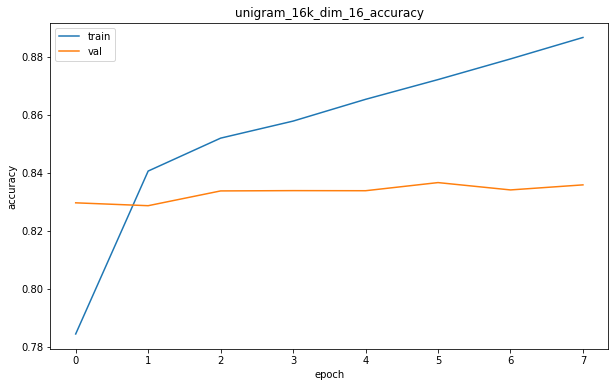

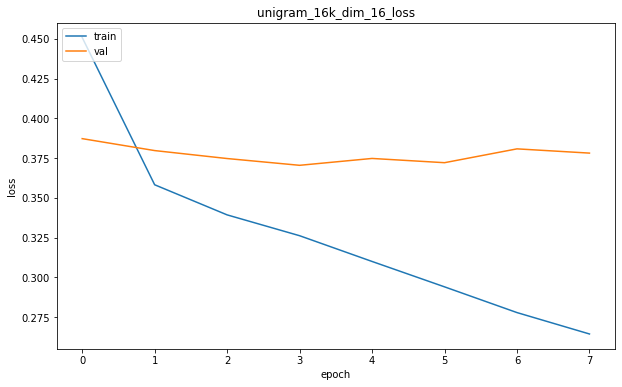

In [78]:
visualize_train(history_unigram_16k_dim_16, param='unigram_16k_dim_16')

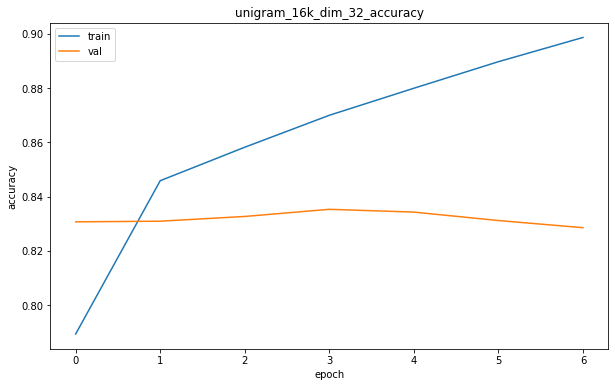

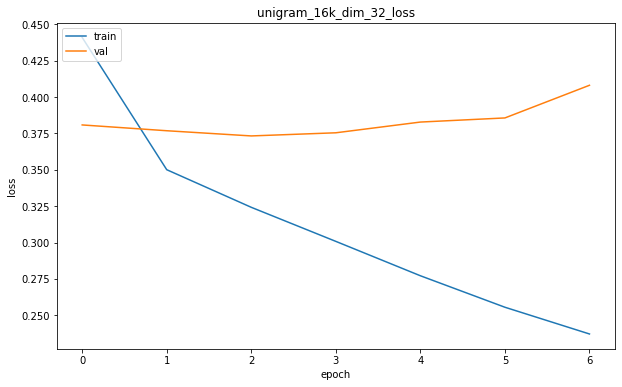

In [79]:
visualize_train(history_unigram_16k_dim_32, param='unigram_16k_dim_32')

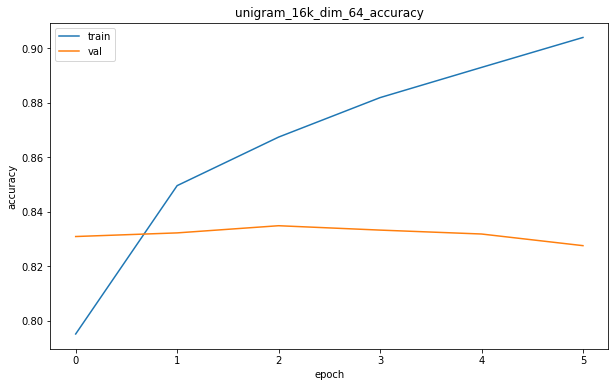

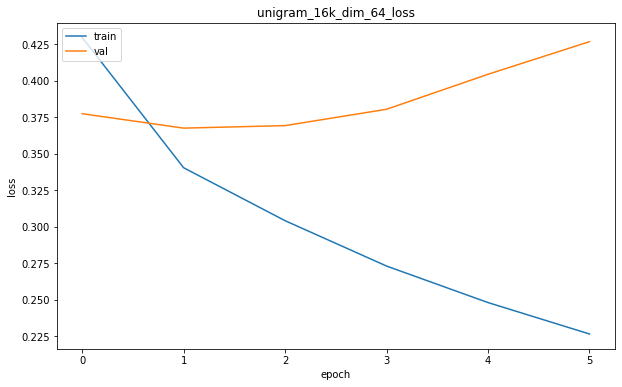

In [80]:
visualize_train(history_unigram_16k_dim_64, param='unigram_16k_dim_64')

In [81]:
history_bpe_4k_dim_8 = performance_test_spm('naver_bpe_4k', vocab_size, word_vector_dim=8)
history_bpe_4k_dim_16 = performance_test_spm('naver_bpe_4k', vocab_size, word_vector_dim=16)
history_bpe_4k_dim_32 = performance_test_spm('naver_bpe_4k', vocab_size, word_vector_dim=32)
history_bpe_4k_dim_64 = performance_test_spm('naver_bpe_4k', vocab_size, word_vector_dim=64)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 8)           64000     
                                                                 
 lstm_13 (LSTM)              (None, 128)               70144     
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 134,273
Trainable params: 134,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1462/1462 [==============================] - 17s 10ms/step - loss: 0.4464 - accuracy: 0.7881 - val_loss: 0.3717 - val_accuracy: 0.8368
Epoch 2/10
1462/1462 [==============================] - 14s 10ms/step - loss: 0.3677 - accuracy: 0.8380 - val_loss: 0.3655 - val_accuracy: 0.8409
Epoch 3/10
1462/146

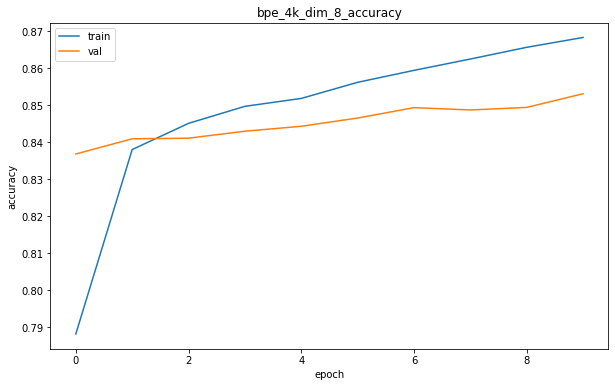

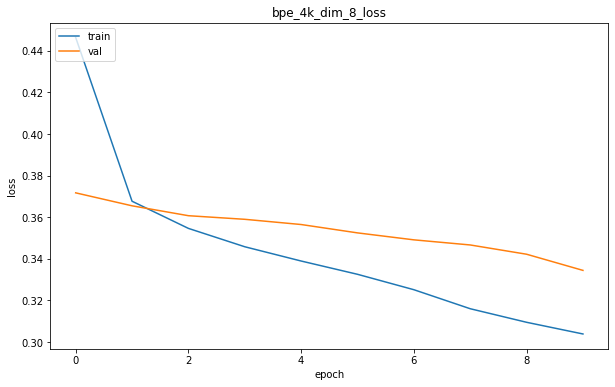

In [82]:
visualize_train(history_bpe_4k_dim_8, param='bpe_4k_dim_8')

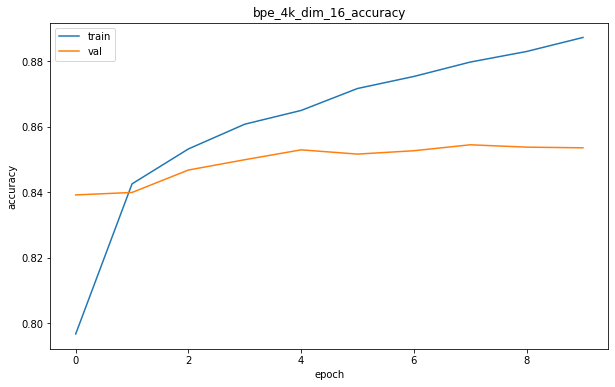

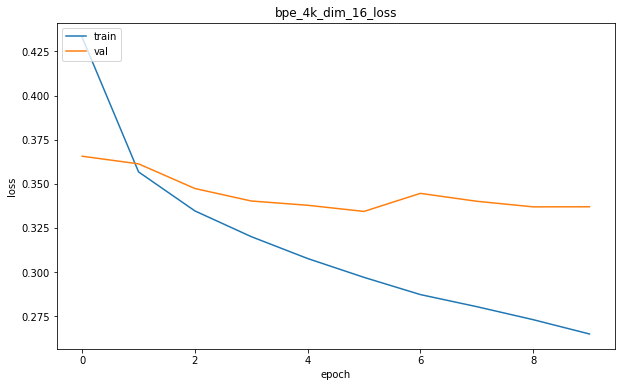

In [83]:
visualize_train(history_bpe_4k_dim_16, param='bpe_4k_dim_16')

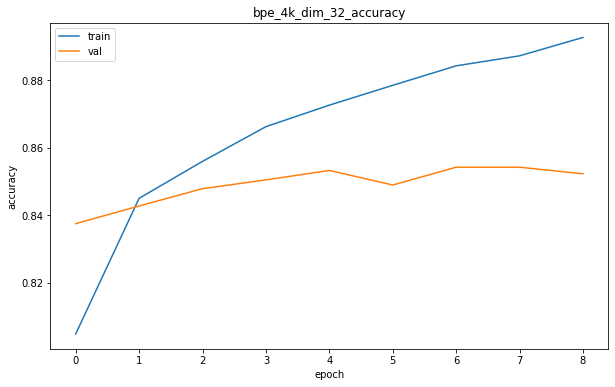

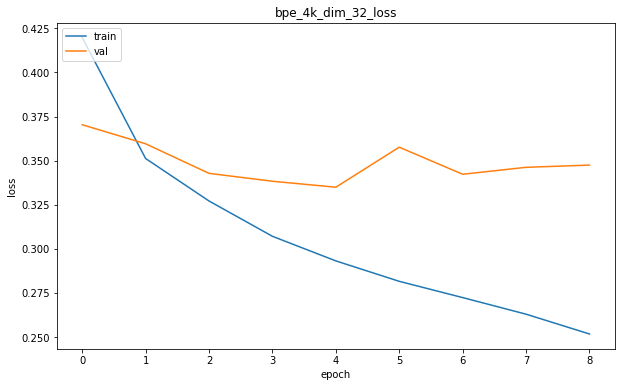

In [84]:
visualize_train(history_bpe_4k_dim_32, param='bpe_4k_dim_32')

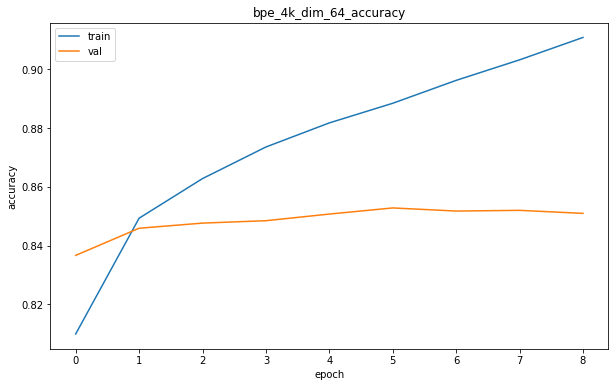

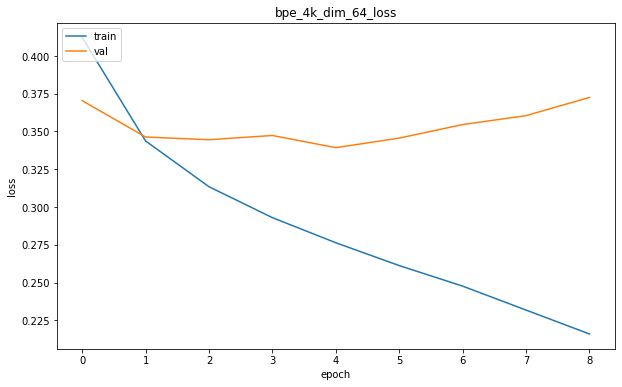

In [85]:
visualize_train(history_bpe_4k_dim_64, param='bpe_4k_dim_64')

In [86]:
history_bpe_8k_dim_8 = performance_test_spm('naver_bpe_8k', vocab_size, word_vector_dim=8)
history_bpe_8k_dim_16 = performance_test_spm('naver_bpe_8k', vocab_size, word_vector_dim=16)
history_bpe_8k_dim_32 = performance_test_spm('naver_bpe_8k', vocab_size, word_vector_dim=32)
history_bpe_8k_dim_64 = performance_test_spm('naver_bpe_8k', vocab_size, word_vector_dim=64)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, None, 8)           64000     
                                                                 
 lstm_17 (LSTM)              (None, 128)               70144     
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 134,273
Trainable params: 134,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1462/1462 [==============================] - 17s 10ms/step - loss: 0.4382 - accuracy: 0.7896 - val_loss: 0.3617 - val_accuracy: 0.8428
Epoch 2/10
1462/1462 [==============================] - 14s 10ms/step - loss: 0.3415 - accuracy: 0.8525 - val_loss: 0.3494 - val_accuracy: 0.8477
Epoch 3/10
1462/146

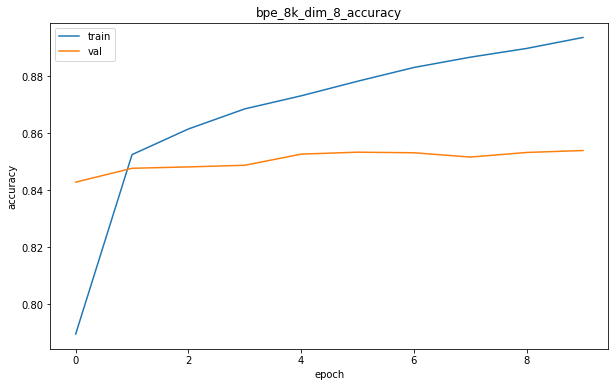

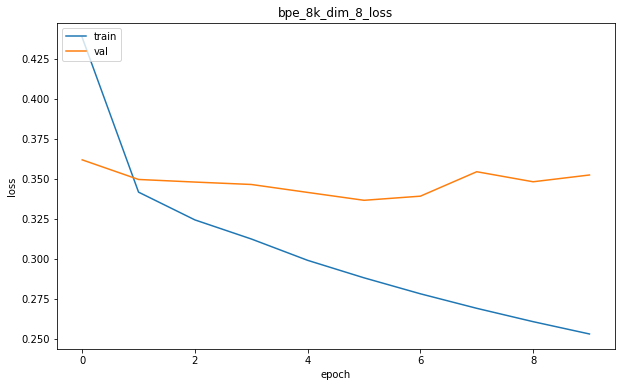

In [87]:
visualize_train(history_bpe_8k_dim_8, param='bpe_8k_dim_8')

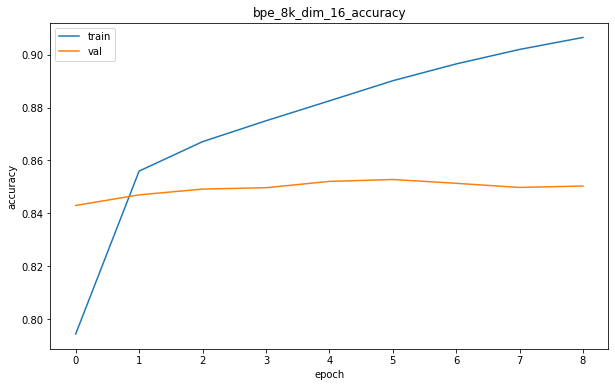

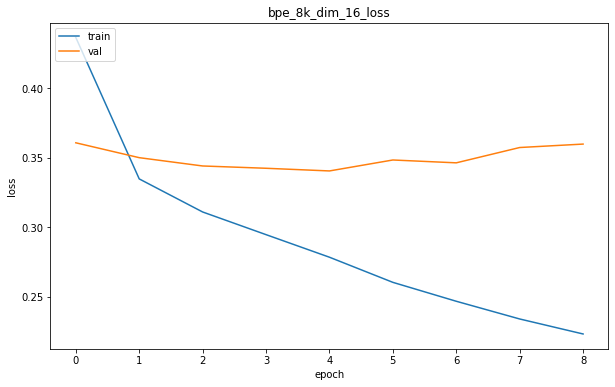

In [88]:
visualize_train(history_bpe_8k_dim_16, param='bpe_8k_dim_16')

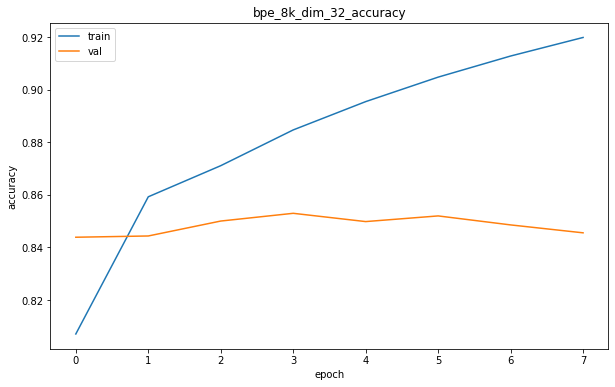

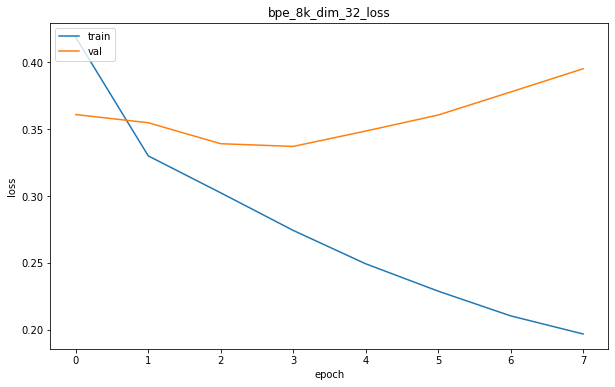

In [89]:
visualize_train(history_bpe_8k_dim_32, param='bpe_8k_dim_32')

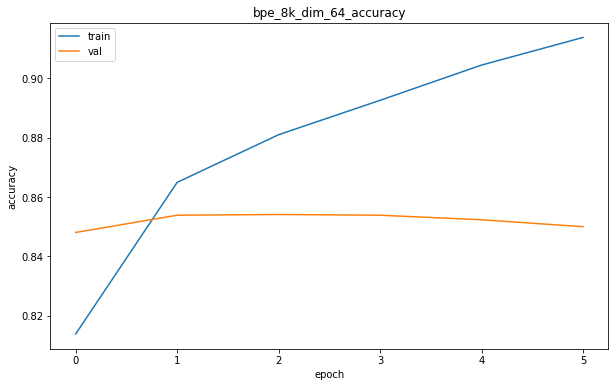

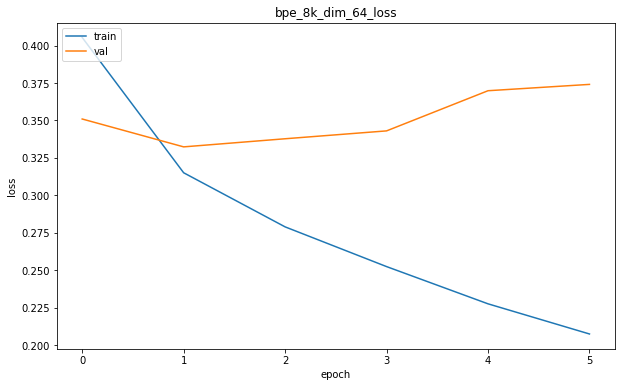

In [90]:
visualize_train(history_bpe_8k_dim_64, param='bpe_8k_dim_64')

In [91]:
history_bpe_16k_dim_8 = performance_test_spm('naver_bpe_16k', vocab_size, word_vector_dim=8)
history_bpe_16k_dim_16 = performance_test_spm('naver_bpe_16k', vocab_size, word_vector_dim=16)
history_bpe_16k_dim_32 = performance_test_spm('naver_bpe_16k', vocab_size, word_vector_dim=32)
history_bpe_16k_dim_64 = performance_test_spm('naver_bpe_16k', vocab_size, word_vector_dim=64)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 8)           64000     
                                                                 
 lstm_21 (LSTM)              (None, 128)               70144     
                                                                 
 dense_21 (Dense)            (None, 1)                 129       
                                                                 
Total params: 134,273
Trainable params: 134,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1462/1462 [==============================] - 17s 10ms/step - loss: 0.4563 - accuracy: 0.7743 - val_loss: 0.3789 - val_accuracy: 0.8304
Epoch 2/10
1462/1462 [==============================] - 14s 10ms/step - loss: 0.3627 - accuracy: 0.8370 - val_loss: 0.3760 - val_accuracy: 0.8323
Epoch 3/10
1462/146

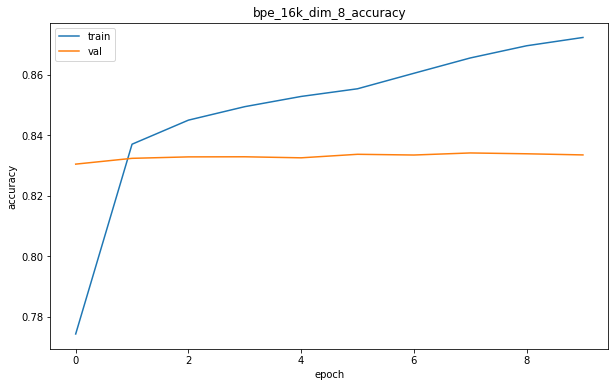

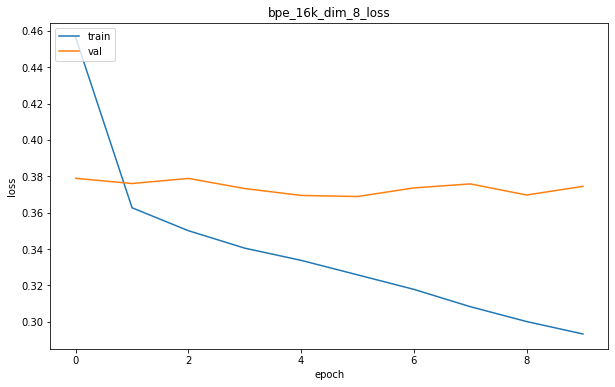

In [92]:
visualize_train(history_bpe_16k_dim_8, param='bpe_16k_dim_8')

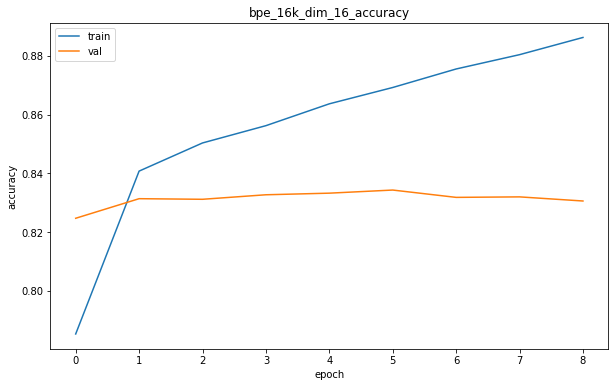

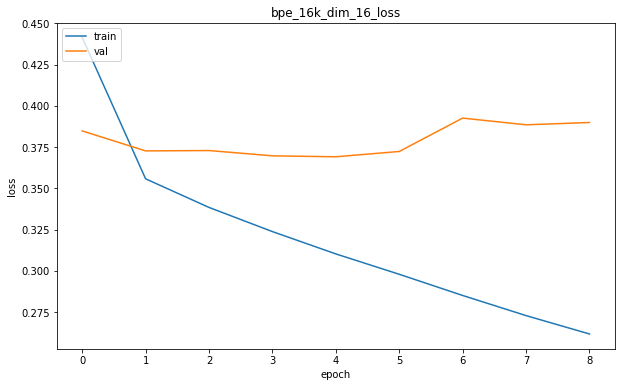

In [93]:
visualize_train(history_bpe_16k_dim_16, param='bpe_16k_dim_16')

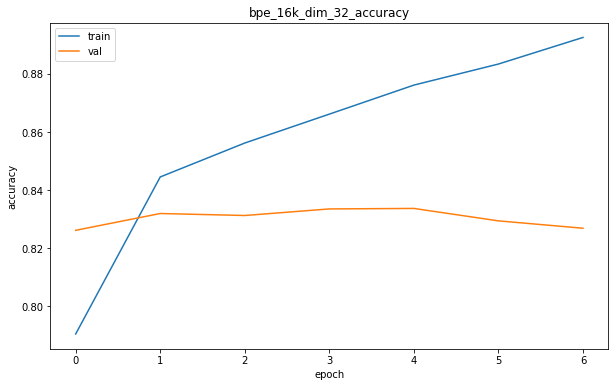

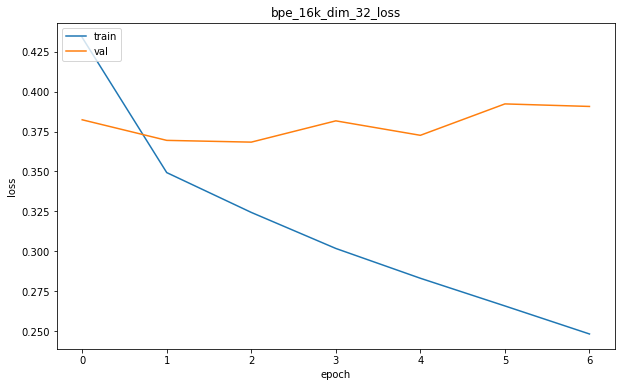

In [94]:
visualize_train(history_bpe_16k_dim_32, param='bpe_16k_dim_32')

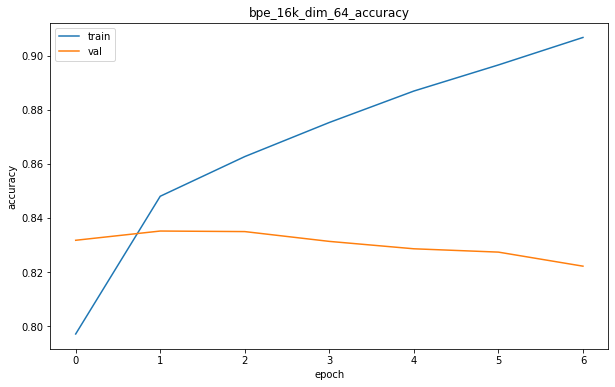

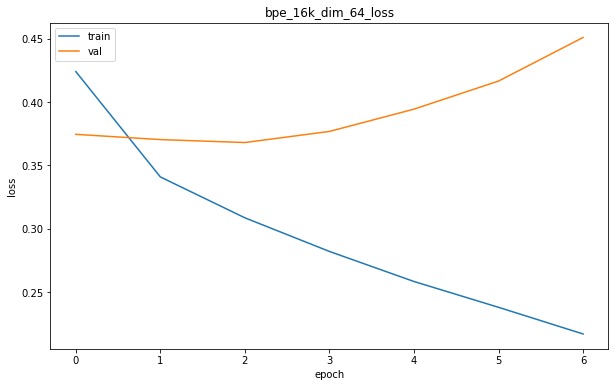

In [95]:
visualize_train(history_bpe_16k_dim_64, param='bpe_16k_dim_64')

-----

## 6. 마치며
첫 고잉디퍼 프로젝트를 수행하는데 시작부터 오류 때문에 순조롭지 못했던 과정들이었다. 할 말이 많으니 순차적으로 정리를 해 보도록 하자.
* `Colab`의 `GPU` 환경에서 모델 학습 시 `Fail to find the dnn implementation.` 오류 발생
  <img src="https://i.ibb.co/3Y5whXp/2022-03-20-02-24-58.png"><br>
  * `Colab`에서 실습을 할 시에는 `GPU`로 환경을 먼저 설정하고 실습을 하는 것이 좋은데, 이는 모델 학습 및 테스트 시 속도의 차이가 나기 때문이다. 이에 따라서 `GPU`로 환경을 설정하고 모델을 학습시키는 과정에서 위와 같은 오류가 생겼고 아래와 같이 두 가지 방법을 시도했으나 실패했다.<br>
    1. 모델의 코드 구조 변경<br>
       - `GPU`를 사용할 때 그 환경에 맞는 코드가 따로 있는 것을 확인하였다.<br>
       - 아래 링크를 참고하여 코드를 수정하였으나, 역시 오류가 해결되지 않았음<br>
         - [구글 코랩(colab) GPU 딥러닝 케라스(keras) 돌리기](https://m.blog.naver.com/demian7607/222043724449)<br>
         - [keras LSTM Fail to find the dnn implementation #36508](https://github.com/tensorflow/tensorflow/issues/36508)<br>
    2. CUDA 재설치 및 환경 설정<br>
       - 근본적인 원인을 찾아보니 `CUDA`, `Tensorflow`, `cuDNN`, `NVIDIA` 버전이 서로 맞지 않거나, 메모리가 부족해서 생기는 문제라고 한다.<br>
       - 그래서 `CUDA`를 다시 설치하고 아래 코드처럼 환경을 설정 해 주었으나...<br>
         `os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'`<br>
  * 초반 코랩에서의 라이브러리 오류 때문에 적잖게 스트레스를 받은 상황이었는데 이제 좀 제대로 해 볼까 싶은 타이밍에 생각지도 못한 오류가 해결이 안 되는 상황 자체가 상당한 스트레스로 다가왔다. 결국 이러다 죽을 것 같아 정신건강을 위해 로컬의 `GPU` 환경을 이용해야겠다!고 생각하게 되는데...(클라우드로도 시도를 해 봤으나, 학습이 너무 느렸다)<br>
* 로컬에서 `GPU` 환경 세팅하기<br>
  * 현재 사용하고 있는 로컬 환경은 아래와 같다.<br>
    * Macbook Pro 16-inch 2019 ver.<br>
    * 2.4Ghz 8Core Intel Core i9<br>
    * 64GB DDR4 RAM<br>
    * AMD Radeon Pro 5500M 8GB<br>
  * 로컬에서 `GPU` 환경으로 작업하기 전에 `terminal`을 이용한 약간의 환경 설정이 필요하다.<br>
    1. `terminal`을 실행 후, `keras` 사용 환경에 `plaidml`을 설치<br>
       `pip install -U plaidml-keras`<br>
    2. 설치가 끝나면, `plaidml` 관련 설정을 위한 명령어를 입력<br>
       `plaidml-setup`<br>
    3. `plaidml` 환경 설정 화면이 표시되면 우리가 사용할 그래픽 카드를 선택 해 주자.<br>
       <img src="https://i.ibb.co/6FmJGzF/2022-03-22-18-50-06.png"><br>
    4. `plaidml` 환경 설정이 끝났으면 잘 돌아가는지 벤치마킹도 해 본다.<br>
       ```
       pip install plaidbench
       plaidbench keras mobilenet
       ```
    5. 필자는 `Mac`을 사용하고 있으므로, `활성 상태 보기`를 실행 후 `cmd+4` 키를 눌러 `GPU`가 잘 돌아가고 있는지 확인한다.<br>
       <img src="https://i.ibb.co/G94rkBP/2022-03-22-18-18-30.png"><br>
  * 그래서 이젠 좀 순조롭게 과제를 할 수 있을까 싶었는데....?<br>
* 로컬 환경에서 `Sentencepiece` 단어 사전 생성 시 속도 저하<br>
  * `BPE` 타입으로 서브워드의 갯수를 8,000개와 16,000개로 지정한 `Sentencepiece` 단어 사전이 1시간이 지나도 생성이 되지 않는 문제가 발생했다. 이 문제에 대한 원인을 구글링을 통해 찾아 보았으나 크게 도움이 되는 내용은 찾지 못하였기 때문에 해당 단어사전은 생성하지 않고 실습을 진행하게 되었다. <br>
  * 과제를 마무리하고 이론적인 내용을 보충하면서 내 스스로 생각하게 된 문제의 원인은, `BPE` 모델이 우선적으로 단어를 글자 단위로 분할한 다음 단어의 집합을 찾아내 사전을 만드는 것 자체가 긴 수행 시간을 필요로 하기 떄문이 아닐까 싶다.<br>
* 69번째 블록의 `indices[0,86] = 15917 is not in [0, 8000)` 오류<br>
  * 모델 학습 및 테스트 중에 발생한 오류인데, 처음에 `Sentencepiece` 단어 사전에서 설정한 단어의 수가 부족해 발생하는 오류라고 한다. 단어의 수를 늘려서 다시 수행하기에는 시간적 한계(`GPU` 환경임에도 모델의 학습과 평가가 드럽게 오래 걸렸다)가 있어 시도하지 못한 부분이 아쉽다.<br>
* 아이펠에서 프로젝트 과제 하면서 회고를 이렇게 길게 써 본 건 처음인 것 같은데... 처음엔 여러 오류 때문에 스트레스를 많이 받았고 Exploration 과제와 달리 자발적으로 수행해야 하는 부분들이 생기면서 과제 수행이 더 어렵게 느껴졌던 것 같다. 비록 오류로 많은 고생을 했지만 LMS에서 주어진 코드대로만 실습하다가 다른 환경에서 라이브러리의 버전 관리나 작업 환경 구축을 처음으로 시도하게 되면서 내가 가지고 있는 컴퓨팅 환경을 제대로 활용할 수 있는 계기가 되었다고 본다. <br>
* 이강산 퍼실님의 조언대로 코랩에서 라이브러리 관련 세팅을 하지 않고 다시 본 과제를 실행 해 본 결과, 정상적으로 작동이 되는 것을 확인할 수 있었다. 너무 먼 길을 돌아 온 느낌이다...
-----

## 7. References
* [[Keras] KoNLPy를 이용한 한국어 영화 리뷰 감정 분석](https://cyc1am3n.github.io/2018/11/10/classifying_korean_movie_review.html)
* [tensorflow GPU 지원](https://www.tensorflow.org/install/gpu)
* [맥북(AMD 560x)에서 딥러닝훈련 방법](http://machinelearningkorea.com/2019/09/15/%EB%A7%A5%EB%B6%81amd-560x%EC%97%90%EC%84%9C-%EB%94%A5%EB%9F%AC%EB%8B%9D%ED%9B%88%EB%A0%A8-%EB%B0%A9%EB%B2%95/)
* [Keras에서 GPU 사용하기 - MacBook 18' pro, Radeon pro 560X 4G](https://kloong.tistory.com/entry/Keras%EC%97%90%EC%84%9C-GPU-%EC%82%AC%EC%9A%A9%ED%95%98%EA%B8%B0-MacBook-18-pro-Radeon-pro-560X-4G?category=1183257)
* [언어모델(Language Model)](https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/09/16/LM/)
* [InvalidArgumentError: indices[26,0]](https://github.com/tensorflow/tensorflow/issues/23698)
* [장단기 메모리(Long Short-Term Memory, LSTM)](https://wikidocs.net/22888)
* 밑바닥부터 시작하는 딥러닝 2
* 혼자 공부하는 머신러닝 + 딥러닝